# Komentáře ke zpracování úlohy pomocí pythonu
## Fyzikální praktikum III, úloha 30, MFF-UK
## Jan Alster, 2023-03-15

Cílem úlohy je určit poloměr křivosti čočky pomocí měření Newtonových kroužků.

## Poznámky k provedení měření
- Je žádoucí dosáhnout rovnoměrného osvětlení zorného pole.
- Obrazy vytvořené mikroskopem uložte ve formátu, který je možné nahrát do pythonu. Vzhledem k možnostem programu u mikroskopu je nejjednodušší volba formát tif.
- Pro použitou metodu zpracování je nutné připravit obrazy horizontálně i vertikálně umístěného měřítka. (Může být zajímavé použít mřížkové měřítko a otáčet čočky pro vyhodnocení vlivu deformace obrazu a rotační asymetrie čoček.)
- Střed kroužků je možné umístit k okraji obrazu - lze tak zaznamenat křivost čočky pro větší vzdálenosti od středu.

## Zpracování dat
Uvedený postup je třeba chápat jako příklad možného zpracování dat. Není to jediný možný postup a pravděpodobně ani ne nejlepší. Jednotlivé kroky může být nutné přizpůsobit individuálnímu provedení experimentu. Není vhodné kód slepě přepisovat bez pochopení významu. Pokud nemáte vlastní počítač s nainstalovaným vývojovým prostředím pro python, lze využít standardní IDLE.

### Načtení obrazů
K načtení využijeme knihovnu `matplotlib`, která je de-facto standard pro vytváření grafů v pythonu.

In [2]:
from matplotlib.image import imread
import matplotlib.pylab as pl
pl.rcParams['figure.figsize'] = [15, 5]  # toto je pouze kosmeticka zalezitost

In [3]:
def nacti_data(jmeno_souboru):
    obraz = imread(jmeno_souboru)[...,0].astype(float)
    return obraz

Funkce `nacti_data()` načte obrázek ve formátu RGB a vrátí kanál R (`[...,0]`) konvertovaný na desetinná čísla (ponechání dat ve formě celých čísel by mohlo vést k výpočetním chybám). Vzhledem k barvě použitého monochromatického světla se kanál R jeví jako optimální volba. Je však možno vybrat i jiné kanály. Případně lze obraz konvertovat do prostoru HSV a použít kanál V:
```   
from matplotlib.colors import rgb_to_hsv
obraz = rgb_to_hsv(imread(jmeno_souboru)/255)[...,2]
```

Načtený obraz lze zobrazit pomocí:
```
pl.imshow(obraz)
pl.colorbar()
```
případně
```
pl.pcolormesh(obraz)
pl.colorbar()
```

### Vyhodnocení měřítka
(Předpokládáme rovnoměrné osvětlení obrazu. Pokud obraz není rovnoměrně osvětlen, může být nutné provést korekci, viz příloha A.)

Pro přesné vyhodnocení je nutné nakalibrovat prostorové osy obrazu z mikroskopu pomocí definovaného měřítka (tedy přechod od pixelů k mikrometrům). Použitý postup využívá celý obraz, tedy ne pouze vybraný řez; je tedy nutné kalibrovat jak horizontální tak vertikální osu.

Postup kalibrace spočívá v nalezení píků odpovídajících čarám měřítka. Toto lze provést ručně (viz příloha B), nebo s poněkud menší přesností využít knihovní funkci, např. `scipy.signal.find_peaks_cwt`.

> Pokud lze využít knihovní funkci, využijte ji! Toto rozhodnutí někdy není jednoduché, protože a) nevíte, jaké knihovní funkce jsou dostupné a b) dostupné knihovní funkce nemusí fungovat přesně podle Vašich představ. Nicméně úspora času bývá značná.  
> https://pypi.org/project/pypeaks/  
> https://pypi.org/project/peakpicker/  
> https://pypi.org/project/peak-finder/

Výstupem je pak kalibrační polynom převádějící pozici obrazu v pixelech na pozici v jednotkách měřítka.

In [4]:
from scipy.signal import find_peaks_cwt
import numpy as np
from numpy.polynomial import Polynomial as poly

def meritko(data, radky, jednotka):
    """
    data: obraz meritka
    radky: pole indexu radku, kde provest kalibraci (pokud meritko neni na vsech radcich obrazu)
    jednotka: vzdalenost car meritka
    """
    
    MM = []
    for radek in radky:
        # find_peaks_cwt hleda maxima, zatimco cary v obraze jsou 
        # minima; [2] reprezentuje ocekavanou sirku piku
        M = find_peaks_cwt(-data[radek], [2])
        MM.append(M)
    
    #Diky pritomnosti necistot mohou byt nalezeny falesne piky.
    # Radky, kde se to stane, budou vyrazeny. Spravny pocet piku urcime podle nejcastejsi hodnoty.
    NN = [len(it) for it in MM]
    #Nejcastejsi delka
    N = np.bincount(NN).argmax()
    MM = [it for it in MM if len(it)==N]
    
    #konverze na numpy.ndarray
    MM = np.asarray(MM)

    #pozice car v jednotkach meritka
    xj = np.arange(N)*jednotka 
    
    #a muzeme nafitovat kalibracni polynom
    # np.tile zopakuje osu xj pro kazdy radek z MM
    # cislo 3 dava stupen kalibracniho polynomu
    #  vic nez stupen 3 nema moc smysl, alespon na testovaci data
    P = poly.fit(MM.flat, np.tile(xj, len(MM)), 3) 
    # volani P(pozice_px) vrati pozice v jednotkach
    
    return P    

Také je vhodné definovat globální veličiny:

In [5]:
dilek = 20 # um, vzdalenost car meritka
vlnova_delka = 0.589 # um (pozor, ve stejnych jednotkach jako meritko)

Ukázka nalezení píků v obraze měřítka:

(300.0, 500.0)

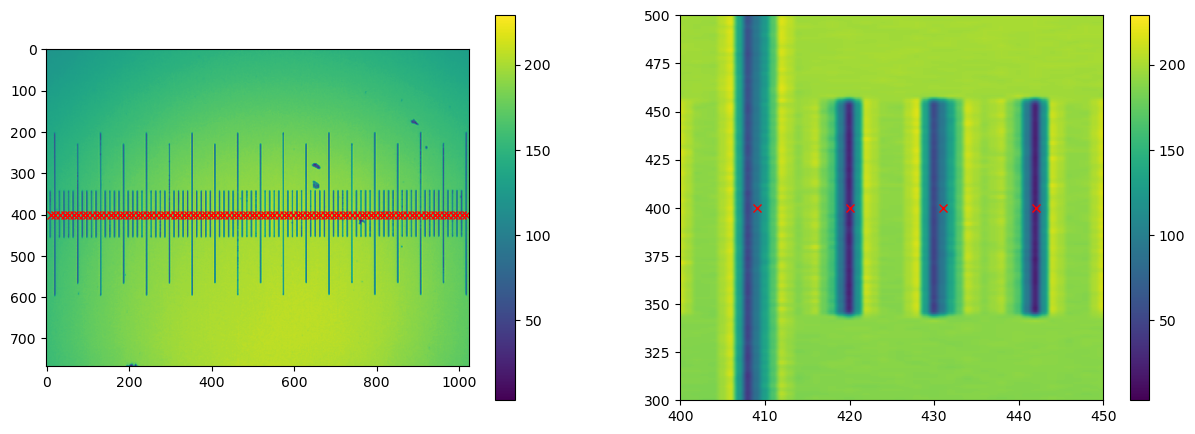

In [6]:
meritkoH = nacti_data("data/c728.tif")
pl.subplot(121)
pl.imshow(meritkoH)
pl.colorbar()
radek = 400
M = find_peaks_cwt(-meritkoH[radek], [2])
pl.plot(M, [400]*len(M), "rx")
pl.subplot(122)
pl.imshow(meritkoH, aspect="auto")
pl.colorbar()
radek = 400
M = find_peaks_cwt(-meritkoH[radek], [2])
pl.plot(M, [400]*len(M), "rx")
pl.xlim(400, 450)
pl.ylim(300, 500)

A vlastní vytvoření kalibračních polynomů:
> Jména souborů, vyběr řádků a jednotku je třeba přizpůsobit.
> Výběr řádků lze automatizovat, ale v případně jednoho měření je ruční výběr rychlejší.
> Výběry řádků lze kombinovat, např. `list(range(340, 360))+list(range(380, 450))` nebo uvést výčtem `[385, 390, 415]`.

In [6]:
meritkoH = nacti_data("data/c728.tif")
PH = meritko(meritkoH, range(350, 450), dilek)

meritkoV = nacti_data("data/c731.tif")
# funkce meritko funguje na radcich, obraz je tedy treba transponovat
PV = meritko(meritkoV.T, range(540, 640), dilek) 

Za předpokladu, že všechny obrazy jsou stejně velké, lze rovnou vytvořit prostorové osy v jednotkách měřítka:
> Pozor, tato kalibrace předpokládá, že obraz je deformovaný rovnoměrně (tedy PH platí pro všechny řádky a PV pro všechny sloupce). Tento předpoklad nemusí být nutně splněn, zejména na krajích obrazu. V principu lze zobrazit místo lineárního měřítka měřítko mřížkové a definovat transformaci (jx, jy) = tr(px, py).

In [7]:
xj = PH(np.arange(meritkoV.shape[1]))
yj = PV(np.arange(meritkoV.shape[0]))

Pro další zpracování předpokládáme dokonalou rotační symetrii. Alternativně lze udělat řez daty a pokračovat analogicky postupu pro Origin.

Pro rotační středování je nutné nalézt střed symetrie. To size lze zcela automatizovat, ale jednodušší a rychlejší je střed naléz (alespoň nahrubo) ručně. 

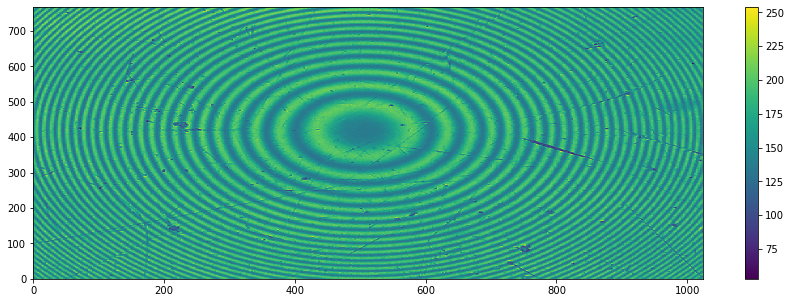

In [8]:
data = nacti_data("data/c734.tif")

pl.pcolormesh(data) 
pl.colorbar()

stredH, stredV = 505, 404

K nalezení přesnější pozice středu symetrie využijeme faktu, že obraz by se neměl měnit, pokud ho zrcadlíme podle středu symetrie. Samotné hledání je implementováno s pevným krokem s omezenou přesností. Bylo by možné fitovat, ale v tomto případě se to zdá být zbytečné, neboť dosažená přesnost je dostatečná a výpočetní čas snesitelný.

In [9]:
def hledej_stred(osa_j, data, stred, P=25):
    """
    osa_j: osa v jednotkach meritka
    stred: priblizna poloha stredu v pixelech
    P: rozsah hledani v pixelech (skutecny stred by mel byt
        v intervalu stred-P, stred+P)
    """
    # kandidati na pozici skutecneho stredu s rozlisenim 0.1pixelu
    t = np.r_[osa_j[stred-P]:osa_j[stred+P]:1j*(P*20+1)] 
    
    # Budeme zrcadlit podle kandidatu na stred a vyhodnocovat prekryv
    # s puvodnim obrazem. Ovsem je nutne zrcadleny obraz interpolovat
    # na puvodni osu.
    def interp2(x, xp, fp):
        # linearni interpolace fp z xp na x
        #hledame x mezi xp a linearni interpolace
        # pro x[k] mezi xp[j] a xp[j+1]
        # fi = fp[j] + (fp[j+1]-fp[j]) * (x[k]-xp[j])/(xp[j+1]-xp[j])
        # fi = fp[j] + np.diff(fp)[j] * (x[k]-xp[j])/np.diff(xp)[j]
    
        j = np.searchsorted(xp, x)-1
        return fp[:,j] + np.diff(fp)[:,j]*((x-xp[j])/np.diff(xp)[j])
    
    #Pole pro ulozeni hodnoceni prekryvu
    Res = np.empty_like(t)
    
    #lehka optimalizace
    data2 = data[:,::-1]
    
    # testovat mozne stredy
    for j, T in enumerate(t):
        #zrcadleni provedeme pomoci otoceni osy
        osa_jrev = (2*T-osa_j)[::-1]
        #pri zrcadleni neni prekryv pres cely obraz, pokud stred neni
        # uprostred obrazu
        mn, mx = osa_j.searchsorted(osa_jrev[[0,-1]])
        data_rev = interp2(osa_j[mn:mx], osa_jrev, data2)
        #volba normy (abs, **2) je otazka vkusu, resp. by mela
        # probehnout pomoci porovnani na testovaci sade dat
        res = np.abs(data_rev-data[:,mn:mx])
        #z miry shody lze vyradit ustrelene body zpusobene necistotami
        Res[j] = res[res<res.std()].mean()
        
    #pokud se chcete podivat na hodnoceni kandidatu
    pl.plot(t, Res)
    
    #lze fitovat a hledat minimum hladke funkce
    #nebo proste vzit minimum (coz muze byt nachylne na lokalni extremy)
    osaj_stred = t[np.asarray(Res).argmin()]
    
    return osaj_stred #v jednotkach meritka 


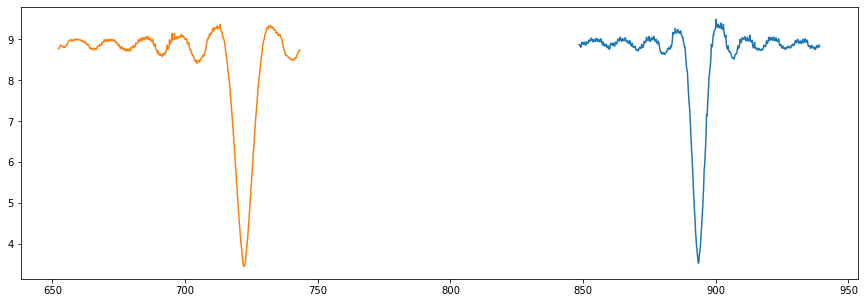

In [10]:
#pozice stredu v jednotkach meritka
xj_stred = hledej_stred(xj, data, stredH)
yj_stred = hledej_stred(yj, data.T, stredV)

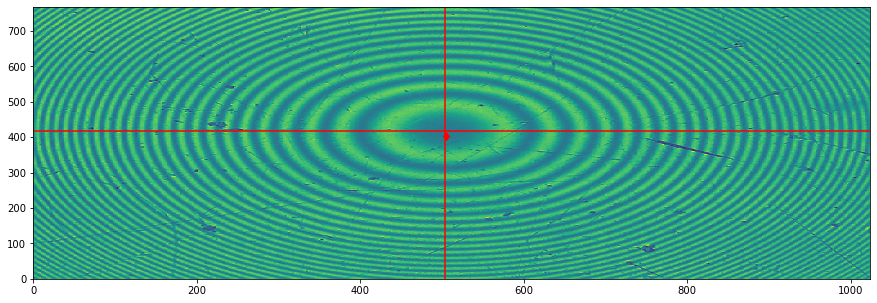

In [11]:
#lze zakreslit pouze priblizne
pl.pcolormesh(data) 
pl.plot([stredH], [stredV], marker="d", color="red")  # puvodni odhad
pl.hlines(yj.searchsorted(yj_stred)-1, 0, data.shape[1], color="red")
pl.vlines(xj.searchsorted(xj_stred)-1, 0, data.shape[0], color="red")

Následně provedeme rotační průměrování: pro každý bod obrazu určíme vzdálenost od středu `RO` a přiřadíme příslušnou amplitudu.

Výsledný signál `A(RO)` by měl podle teoretických předpokladů odpovídat vztahu
> `A(RO) = amplituda(RO) * 0.5 * (1 - cos(2*pi*2/vlnova_delka*(d+t(RO)))) + pozadi(RO)`

kde
- `amplituda(RO)` souvisí s intenzitou světla odraženého od jednotlivých rozhraní a určuje hloubku modulace (a neměla by se s `RO` měnit příliš)
- `d` je neznámá minimální mezera mezi čočkou a destičkou, kterou nepotřebujeme určit přesně
- `t(RO)` je tloušťka vrstvy mezi čočkou a destičkou ve vzdálenosti `RO` od středu
- `pozadi(RO)` souvisí s osvětlením zorného pole (a také by se nemělo s `RO` měnit příliš)

Přičemž nás zajímá `t(RO)`, tedy fáze (vnitřek `cos()`).

Text(0, 0.5, 'A')

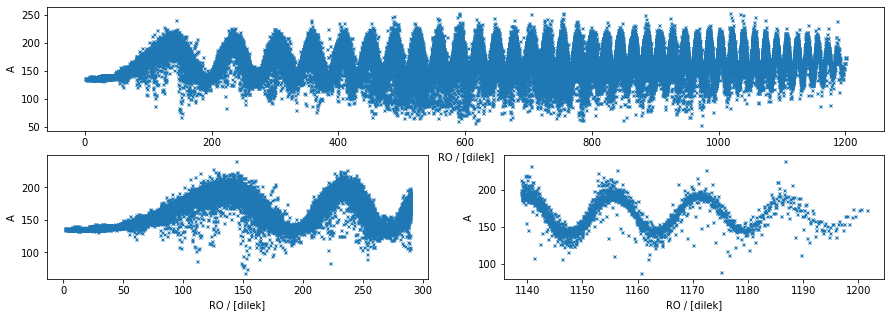

In [12]:
RO = []
A = []

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        RO.append(((xj[j]-xj_stred)**2+(yj[i]-yj_stred)**2)**0.5) #polomer v jednotkach
        A.append(data[i,j])

#usporadani a konverze na np.ndarray   
RO, A = np.array(sorted(zip(RO, A))).T

pl.subplot(211)
pl.plot(RO, A, linestyle="", marker="x", markersize=3)
pl.xlabel("RO / [dilek]")
pl.ylabel("A")
pl.subplot(223)
pl.plot(RO[:80000], A[:80000], linestyle="", marker="x", markersize=3)
pl.xlabel("RO / [dilek]")
pl.ylabel("A")
pl.subplot(224)
pl.plot(RO[-2000:], A[-2000:], linestyle="", marker="x", markersize=3)
pl.xlabel("RO / [dilek]")
pl.ylabel("A")


Fázi můžeme určit fitováním; pak ale musíme fitovat i `amplituda(RO)` a `pozadi(RO)`, protože se nám je nejspíše nepodaří odstranit jinak.

Alternativně lze využít vlastnosti Fourierovy transformace. Pro správné fungování potřebuje FFT (Fast Fourier Transform) ekvidistantní `RO` a data tak je třeba částečně vyprůměrovat. Volba délky intervalu `RO` je provedena tak, aby v každém intervalu byly alespoň 3 body. Přičemž předpokládáme, že hustota bodů klesá s rostoucím `RO` (to odpovídá rohům obrázku). 

Text(0, 0.5, 'A')

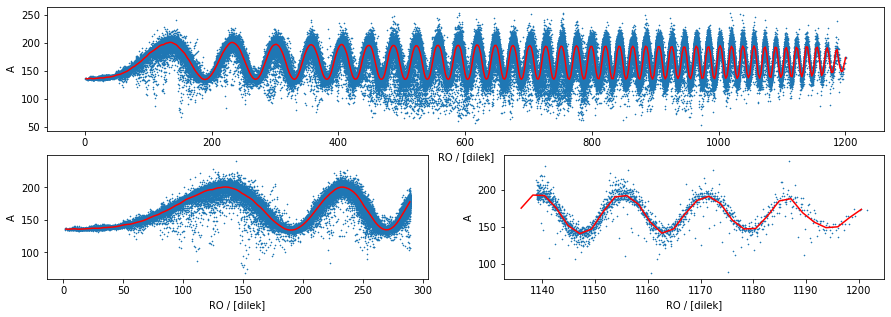

In [19]:
dRO = RO[-1]-RO[-4]
ROE = np.arange(RO[0], RO[-1], dRO)
i = RO.searchsorted(ROE)
splitA = np.split(A,i[1:])
AE = np.asarray([it.mean() for it in splitA])  # zde by bylo mozne vyradit ustrelene body
ROE = ROE + dRO/2  # posun na stred intervalu

pl.subplot(211)
pl.plot(RO, A, linestyle="", marker="x", markersize=1)
pl.plot(ROE, AE, color="red")
pl.xlabel("RO / [dilek]")
pl.ylabel("A")

pl.subplot(223)
pl.plot(RO[:80000], A[:80000], linestyle="", marker="x", markersize=1)
pl.plot(ROE[:130], AE[:130], color="red")
pl.xlabel("RO / [dilek]")
pl.ylabel("A")

pl.subplot(224)
pl.plot(RO[-2000:], A[-2000:], linestyle="", marker="x", markersize=1)
pl.plot(ROE[-30:], AE[-30:], color="red")
pl.xlabel("RO / [dilek]")
pl.ylabel("A")

Samotný trik pro určení fáze funguje tak, že se provede FFT a následně se zruší absolutní člen a záporné frekvence. Zpětná FFT pak rekonstruuje signál (posunutý k nulové amplitudě), ale v komplexních číslech. Fázi pak můžeme určit přímo. Metoda funguje dobře i pro určité fluktuace `amplituda(RO)` a `pozadi(RO)`, které tak můžeme ignorovat (ovšem nesmí se to přehánět). 

Text(0, 0.5, 'amplituda Fourierovy transformace A')

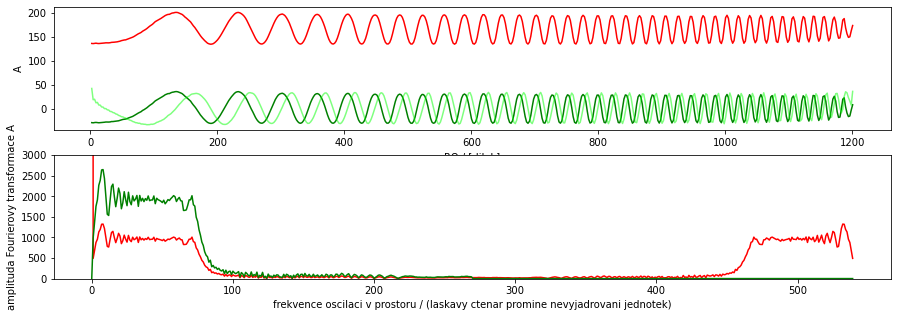

In [22]:
ft = np.fft.fft(AE)
ft_back = np.array(ft)
N = len(ft)//2
ft[N:] = 0
ft[0] = 0

# pro udrzeni amplitudy je nutne kompenzovat
ft *= 2

AE2 = np.fft.ifft(ft)
pl.subplot(211)
pl.plot(ROE, AE, color="red")
pl.plot(ROE, AE2.real, color="green")
pl.plot(ROE, AE2.imag, color="lime", alpha=0.5)
pl.xlabel("RO / [dilek]")
pl.ylabel("A")

#fazi urcime jednoduse z komplexni verze signalu    
faze = np.unwrap(np.angle(AE2))

pl.subplot(212)
pl.plot(np.abs(ft_back), color="red")
pl.plot(np.abs(ft), color="green")
pl.ylim(0, 3000)
pl.xlabel("frekvence oscilaci v prostoru / (laskavy ctenar promine nevyjadrovani jednotek)")
pl.ylabel("amplituda Fourierovy transformace A")

Samotnou tloušťku vrstvy vzduchu mezi čočkou a destičkou určíme z fáze přímočaře:
> `faze = 2*pi*2/vlnova_delka * (d + t(ROE))`  
` t(ROE) = faze * vlnova_delka / (4*pi) - dd`

kde `dd` je neznámá a nezajímavá konstanta.

Text(0, 0.5, 'tloustka vrstvy / [dilek]')

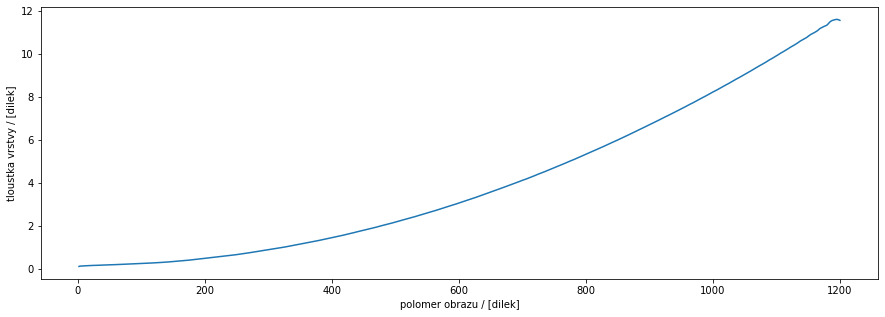

In [15]:
vrstva = faze * vlnova_delka / (4*np.pi) # = d + t(RE)

pl.plot(ROE, vrstva, label="vrstva")
pl.xlabel("polomer obrazu / [dilek]")
pl.ylabel("tloustka vrstvy / [dilek]")

Tloušťku vrstvy mezi čočkou a destičkou můžeme považovat za experimentálně určenou (metoda bude fungovat i pro nesférickou čočku, i když předpokládáme rotační symetrii). Lze i ověřit, jestli je čočka kulová pomocí fitování příslušného modelu.

> `vrstva = R - (R**2 - ROE**2)**0.5 + dd`

kde `R` je poloměr křivosti čočky.

Text(0, 0.5, 'rezidua / [dilek]')

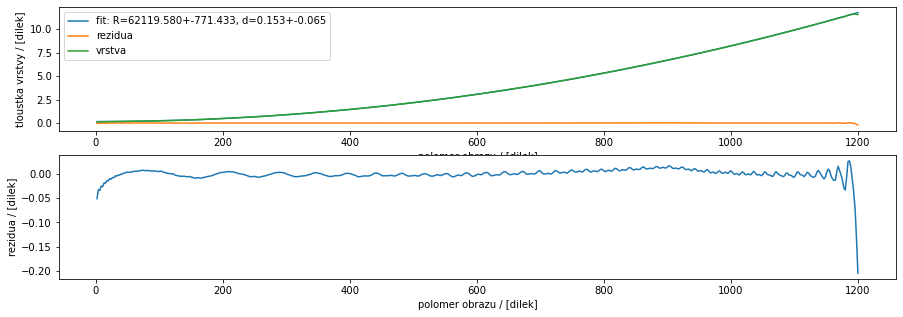

In [23]:
from scipy.optimize import curve_fit
#Optimalizacni funkce scipy.optimize.curve_fit umoznuje pri fitovani
# zohlednit nejistotu vstupnich dat (zavisle promenne) a to i absolutne.
# To zde nedelame. Zvidavy ctenar muze snadno doplnit.
#pozn: pokud potrebujete zohlednit i nejistoty nezavisle promenne, 
# podivejte se na https://stackoverflow.com/a/26085136

def model(ro, R, d):
    return d+R-(R**2-ro**2)**0.5

#Odhad pocatecnich parametru
# d+R-(R**2-ro**2)**0.5
# ro = 0 -> y = d
# vrstva[-1] = d0 + R-(R**2-ROE[-1]**2)**0.5
# (vrstva[-1] - d0 - R)**2 = R**2-ROE[-1]**2
# (vrstva[-1] - d0)**2 - 2* (vrstva[-1] - d0) * R + R**2 = R**2 - ROE[-1]**2
#  R  = (ROE[-1]**2 + (vrstva[-1] - d0)**2) / (2* (vrstva[-1] - d0))
d0 = vrstva[0]
R0 = (ROE[-1]**2 + (vrstva[-1] - d0)**2) / (2* (vrstva[-1] - d0))
p0 = (R0, d0) #pozor, R musi byt vetsi nez maximalni RO

p, pcov = curve_fit(model, ROE, vrstva, p0, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
#Pozor, takto urcene nejistoty parametru fitu sice zohlednuji nejistotu
# vstupnich dat, ale nemusi byt vzdy realisticke, zejmena pokud jsou
# parametry modelu silne korelovane.


#jednotky parametru fitu odpovidaji jednotkam meritka a vlnove delky
#(pozor, zde nedelame spravne zaokrouhleni)
pl.subplot(211)
pl.plot(ROE, model(ROE, *p), 
        label="fit: R={0:.3f}+-{2:.3f}, d={1:.3f}+-{3:.3f}".format(*p, *perr))
#je vhodne se podivat na rezidua - tak se nejlepe projevi (ne)vhodnost modelu
pl.plot(ROE, vrstva - model(ROE, *p), label="rezidua")     
pl.plot(ROE, vrstva, label="vrstva")
pl.xlabel("polomer obrazu / [dilek]")
pl.ylabel("tloustka vrstvy / [dilek]")
pl.legend()

# Rezidua zachycuji odchylky urceneho prubehu od modelu. 
# Odchylky mohou byt zpusobeny bud chybami mereni anebo nedokonalosti cocky samotne.
pl.subplot(212)
pl.plot(ROE, vrstva - model(ROE, *p), label="rezidua")     
pl.xlabel("polomer obrazu / [dilek]")
pl.ylabel("rezidua / [dilek]")


To je vše. Připomínky a dotazy můžete směřovat na autora textu na emailu jan.alster@mff.cuni.cz.



In [17]:
#- Priloha A ---------------------------------------------------
# Korekce nerovnomerneho osvetleni
def normalizovat(data, N=50, M=150, PI=15, PS=85):
    """
    data - data k normalizovani
    N - pocet zkoumanych bodu i, j
    M - prohledavane okoli je brano jako data[i-M:i+M, j-M:j+M]
    PI - percentil pro spodni mez
    PS - percentil pro horni mez
    
    Normalizovani je zalozeno na hledani minimalni a maximalni
    hodnoty na okoli. Pricemz uvazujeme 15. a 85. percentil
    pro omezeni vlivu extremu. Siri okoli je nutne prizpusobit tak,
    aby bylo vetsi nez perioda signalu. Pocet zkoumanych okoli
    je take mozne menit. Vysledny mezni signal (infimum nebo supremum)
    je pak dany prumerem pres zkoumana okoli.
    
    (Alternativne lze pro kazdy bod uvazovat jeho vlastni okoli, coz
     je ale vypocetne lehce narocnejsi.)
    """
    S = np.zeros_like(data)
    I = np.zeros_like(data)
    SN = np.zeros_like(data, dtype=int)
    IN = np.zeros_like(data, dtype=int)
    
    for i in np.r_[M:data.shape[0]-M:N*1j].astype(int):
        for j in np.r_[M:data.shape[1]-M:N*1j].astype(int):
            temp = data[i-M:i+M, j-M:j+M]
            ii, ss = np.percentile(temp, (PI, PS))
            I[i-M:i+M, j-M:j+M] += ii
            S[i-M:i+M, j-M:j+M] += ss
            IN[i-M:i+M, j-M:j+M] += 1
            SN[i-M:i+M, j-M:j+M] += 1
            
    I /= IN
    S /= SN
    
    """
    Zde je mozne jeste zjistene mezni plochy prolozit hladkou funkci.
    Jeste lepe se tak eliminuje vliv extremu. 
    (V pripade pouziti lze volit mensi okoli M.)
    """
    # I = proloz_plochu(I)
    # S = proloz_plochu(S)
    
    ndata = (data-I)/(S-I)
    return ndata

def proloz_plochu(data):
    x = np.r_[-1:1.:1j*data.shape[0]]
    y = np.r_[-1:1.:1j*data.shape[1]]
    
    X, Y  = np.meshgrid(x, y)

    #volba baze tvorici plochu zavisi na pozadovanem modelu
    # basis = [np.ones_like(X), X, Y, X**2, Y**2, X*Y]
    # basis = [np.ones_like(X), X, Y]
    basis = []
    for ix in range(6):
        for iy in range(6):
            basis.append(X**ix * Y**iy)
    
    #TODO: this is weird, it will not fit well without .T here
    # but with it, it will switch X and Y ???
    # it does not matter for result here, but I need to figure this out
    basis_flat = np.array([it.T.flatten() for it in basis])

    data_flat = data.flatten()
    
    # M = C . basis
    basis_flatI = np.linalg.pinv(basis_flat)
    C = np.dot(data_flat, basis_flatI)
    
    M = np.tensordot(C, basis, 1).T
    
    #muzeme z prolozeni vyloucit ustrelene hodnoty
    for i in range(3):
        M_flat = M.flatten()
        d = data_flat-M_flat
        std = d.std()
        
        #pozice ustrelenych hodnot
        I = np.abs(d)>2*std

        #nahrazene ustrelenych hodnot modelem z predchozi iterace 
        # neni dokonale reseni, ale staci
        data_flat[I] = M_flat[I]
        C = np.dot(data_flat, basis_flatI)
        
        M = np.tensordot(C, basis, 1).T
    
    return M
    


In [18]:
#- Priloha B ---------------------------------------------------
# Nalezeni piku v datech


def scaleH(data, radek, prvni, posledni, N):
    """
    radek - index radku, kde se ma provadet kalibrace
    prvni - px pozice prvni cary (staci priblizne)
    posledni - px pozice posledni cary (staci priblizne)
    N - pocet car
    
    (piky lze hledat automaticky, ale rychlejsi je je zadat rucne)
    """
    #prvni, posledni a N lze najit automaticky, ale prijde mi to
    # moc na PIII
    
    dr = data[radek].astype(float)
    x = np.arange(len(dr))
    
    d = (posledni-prvni)/N
    #hranice, posunute o pul intervalu mezi carami
    # pojistka pro pripad ze by cary byly prilis blizko kraji
    I = np.r_[max(0,prvni-0.5*d):min(posledni+0.5*d, len(dr)):(N+1)*1j].astype(int)
    
    
    # pl.plot(I, [radek]*len(I), linestyle="", marker="x")

    #rozdelit radek na jednotlive cary    
    drs = np.split(dr, I)
    xs = np.split(x, I)
    
    #pro kazdou caru najit stred
    # - mozno fitovat zvoleny prubeh (napr. gaussovku)
    # - mozno hledat stred symetrie (to se dela obtizne s presnosti lepsi nez 1 px)
    # - lze vyuzit derivaci
    
    M = [] #vysledne pozice car

    for x, y in zip(xs,drs):
        # preskocit okrajove prilis kratke intervaly
        if len(x) < 5: continue
        # print(x, y)
        
        #spocitat derivaci
        dx = x[:-1]+0.5 #0.5px za ztratu bodu v np.diff
        dy = np.diff(y)
        # print(dx, dy)
        
        #hledame nejvetsi zmenu - to by melo byt pres caru
        jn = dy.argmin()
        jx = dy.argmax()+1
        # print(jn, jx)
        
        tx = dx[jn:jx]
        ty = dy[jn:jx]
        
        # print(tx, ty)
        
        # do okoli nejvetsi zmeny prolozime primku
        p = poly.fit(tx, ty, 1)
        
        # a urcime prusecik s 0
        m = p.roots()[0]
        M.append(m)
        # pl.plot((m,m), (-50,200), color="purple")
    
        # pl.plot(x, y)
        # pl.plot(dx, dy)

    pl.plot(M, [radek]*len(M), linestyle="", marker="x")    
    return M    
